# Quantum Sentence Classifier

Train a pure quantum model using PennyLane and PyTorch to classify whether a sentence is about cooking or computing. 

(Source: https://cqcl.github.io/lambeq/examples/pennylane.html)

In [27]:
print("###################################")
print("### Quantum Sentence Classifier ###")
print("###################################")

###################################
### Quantum Sentence Classifier ###
###################################


## Preparation - Hyperparameters

In [11]:
BATCH_SIZE = 5
EPOCHS = 20
LEARNING_RATE = 0.1
SEED = 9

## Imports

In [12]:
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from lambeq import PytorchTrainer, BobcatParser, remove_cups, AtomicType, IQPAnsatz, PennyLaneModel, Dataset
from pytket.extensions.qiskit import tk_to_qiskit

# import pennylane as qml
# from qiskit import Aer, execute, IBMQ

## Set seeds

In [13]:
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

## Read data from files

In [14]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = float(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences

train_labels, train_data = read_data('datasets/train_data.txt')
dev_labels, dev_data = read_data('datasets/dev_data.txt')
test_labels, test_data = read_data('datasets/test_data.txt')

## Create diagrams

Creation of the diagrams for the given data sets...



Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.
Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


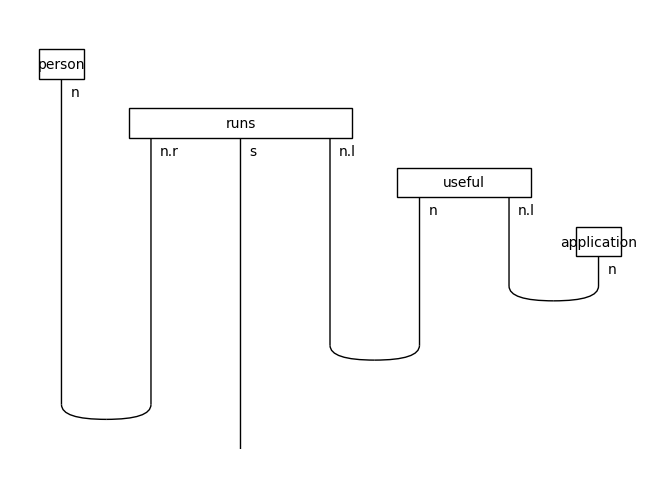

In [15]:
print('Creation of the diagrams for the given data sets...\n')
reader = BobcatParser(verbose='text')

raw_train_diagrams = reader.sentences2diagrams(train_data)
raw_dev_diagrams = reader.sentences2diagrams(dev_data)
raw_test_diagrams = reader.sentences2diagrams(test_data)
# Show one example raw diagram
diagram_0 = raw_train_diagrams[7]
diagram_0.draw(output="mpl")
# diagram_0.save('example-circuit-diagram-0.jpg')

## Remove cups

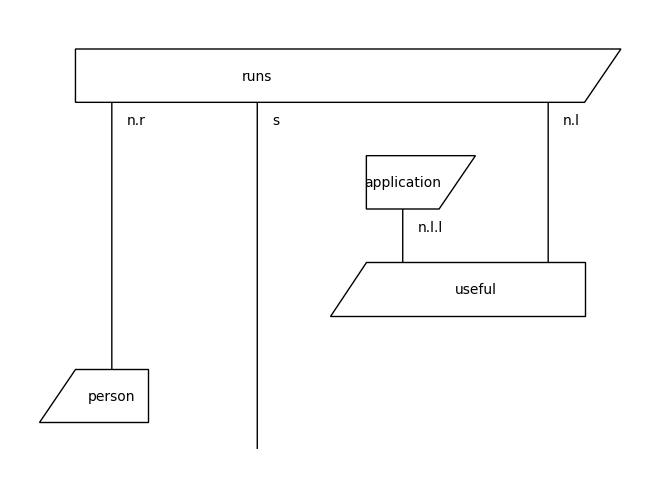

In [16]:
train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]
# Show one example diagram with removed cups
train_diagrams[7].draw(output="mpl")

## Create DisCoPy circuits

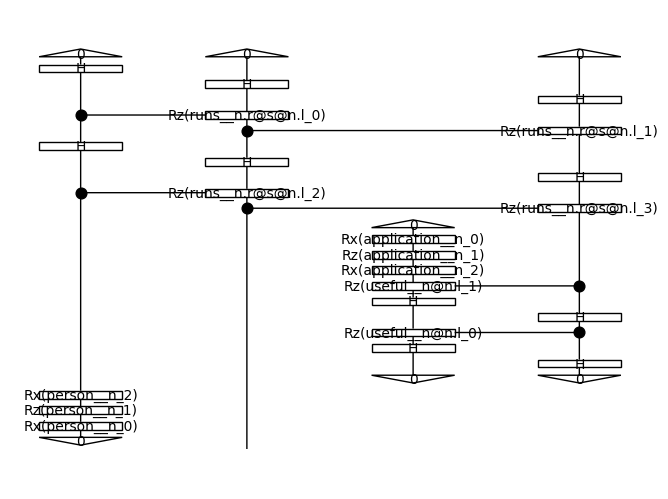

In [17]:
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1, AtomicType.PREPOSITIONAL_PHRASE: 1, AtomicType.CONJUNCTION: 1},
                   n_layers=2, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]
# Show one example circuit
train_circuits[7].draw(output="mpl")

## Transform one example circuit to Qiskit format (conversion to pytket format & export)

In [18]:
tket_circuit = train_circuits[7].to_tk()
qiskit_circuit = tk_to_qiskit(tket_circuit)
plt = qiskit_circuit.draw(output="mpl")
# plt.show()
plt.savefig('example-circuit-diagram-qiskit.jpg')

C:\Users\jonas.vanbebber\AppData\Local\Temp\ipykernel_17100\1021646503.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plt.show()


## Combine all circuits

In [19]:
all_circuits = train_circuits + dev_circuits + test_circuits

## Create Quantum model and initialize parameters

Choose a backend (default: PennyLane simulator - used if no backend_config is provided)

In [20]:
backend_config = {'backend': 'default.qubit'}
model = PennyLaneModel.from_diagrams(all_circuits,
                                     probabilities=True,
                                     normalize=True,
                                     backend_config=backend_config)
model.initialise_weights()

# Run the program on a real quantum computer, backend: ibmq_qasm_simulator

# qml.default_config['qiskit.ibmq.ibmqx_token'] = 'ibm-token'
# qml.default_config.save(qml.default_config.path)
# backend_config = {'backend': 'qiskit.ibmq',
#                  'device': 'ibmq_qasm_simulator',
#                  'shots': 10,
#                  'probabilities'=True}
# model = PennyLaneModel.from_diagrams(all_circuits, backend_config=backend_config)
# model.initialise_weights()

## Prepare train and val datasets

In [21]:
train_dataset = Dataset(train_circuits,
                        train_labels,
                        batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, 
                      dev_labels,
                      batch_size=BATCH_SIZE)

## Train a model with PytorchTrainer & save to file or load trained model from file 

In [22]:
print('\nTrain a model with PytorchTrainer or load trained model from file:')
answer_training = input("Press 'y' to train & save the circuit model or any other key to load existing model ('model.pth')...\n")
if answer_training in ['y', 'Y']: 

    def acc(y_hat, y):
        return (torch.argmax(y_hat, dim=1) ==
                torch.argmax(y, dim=1)).sum().item()/len(y)

    def loss(y_hat, y):
        return torch.nn.functional.mse_loss(y_hat, y)

    trainer = PytorchTrainer(
            model=model,
            loss_function=loss,
            optimizer=torch.optim.Adam,
            learning_rate=LEARNING_RATE,
            epochs=EPOCHS,
            evaluate_functions={"acc": acc},
            evaluate_on_train=True,
            use_tensorboard=False,
            verbose='text',
            seed=SEED
            )

    trainer.fit(train_dataset, val_dataset)

    # Save model to file
    torch.save(model.state_dict(), 'model.pth')

else: 
    # Load model from file
    model.load_state_dict(torch.load('model.pth'))
    model.eval()


Train a model with PytorchTrainer or load trained model from file:


## Compute & print accuracy of the used model

In [23]:
def accuracy(circs, labels):
    probs = model(circs)
    return (torch.argmax(probs, dim=1) ==
            torch.argmax(torch.tensor(labels), dim=1)).sum().item()/len(circs)

accuracy(test_circuits, test_labels)

print('Final accuracy: {}'.format(accuracy(test_circuits, test_labels)))



Final accuracy: 1.0




## Check output for two example test circuits

In [24]:
# 1: Sentence about cooking
print(test_data[0])
p_circ = test_circuits[0].to_pennylane(probabilities=True)
p_circ.initialise_concrete_params(model.symbols, model.weights)
unnorm = p_circ.eval().detach().numpy()
print(unnorm / np.sum(unnorm))
print('\n')

# 2: Sentence about IT
print(test_data[2])
p_circ = test_circuits[2].to_pennylane(probabilities=True)
p_circ.initialise_concrete_params(model.symbols, model.weights)
unnorm = p_circ.eval().detach().numpy()
print(unnorm / np.sum(unnorm))

woman prepares tasty dinner .
[0.98483014 0.01516986]


skillful woman prepares software .
[0.04294879 0.95705121]


## Test model predictions with new user input sentences

In [25]:
more_tests = True

while more_tests:
    try:
        print("\n")
        answer1 = input("\nType in input sentence:... (or 'q' to exit program)\n")

        if answer1 in ['q', 'Q']:
            exit()
        
        answers = [answer1]

        answer1_raw_diagrams = reader.sentences2diagrams(answers)
        answer1_diagrams = [remove_cups(diagram) for diagram in answer1_raw_diagrams]
        answer1_circuits = [ansatz(diagram) for diagram in answer1_diagrams]

        p_circ = answer1_circuits[0].to_pennylane(probabilities=True)
        p_circ.initialise_concrete_params(model.symbols, model.weights)
        unnorm = p_circ.eval().detach().numpy()

        print("\n")
        print(answer1)
        print(unnorm / np.sum(unnorm))
        
    except (ValueError, RuntimeError, TypeError, NameError, ImportError) as inst:
        print(type(inst)) # Exception type
        print(inst) # Exception message


Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


<class 'NameError'>
name 'test__n' is not defined




Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.




man prepares meal
[9.99121557e-01 8.78442829e-04]




Tagging sentences.
Parsing tagged sentences.
Turning parse trees to diagrams.


SyntaxError: invalid syntax (<lambdifygenerated-1483>, line 3)